In [43]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.formula.api import *
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pprint import pprint
import time

#### Classifying trip

Proposed attribute:
- RatecodeID
- Estimated trip distance and time
- Day and hour
- Temperature and precipitation
- destination

In [7]:
def equal_sample(data, att, n):
    lst_data = []
    unique_att = data[att].unique()
    for each_label in unique_att:
        lst_data.append(data[data[att]==each_label].sample(n=n))
    samples = lst_data[0]
    for each_data in lst_data[1:]:
        samples = pd.concat([samples, each_data])
    return samples

In [44]:
# open data
X_train = pd.read_feather('X_train.feather')
X_test = pd.read_feather('X_test.feather')

In [45]:
X_train.shape

(10291258, 14)

In [46]:
X_test.shape

(5132810, 15)

In [194]:
X_train.drop(labels=['date', 'PULocationID', 'DOLocationID', 'fare_amount', 'misc_amount'], axis=1, inplace = True)
X_test.drop(labels=['date', 'PULocationID', 'DOLocationID', 'fare_amount', 'misc_amount'], axis=1, inplace = True)

In [21]:
target_names = ['1', '2', '3', '4']

In [6]:
plt.figure(figsize=(8, 6))
plt.plot()

,RatecodeID,hour,trip_distance,time,cluster_trip,day_of_week,precip,temp,destination
0,1.0,10,1.270000,0.121389,1,1,0.0,14.0,1
1,5.0,10,21.090000,0.603056,2,1,0.0,14.0,2
2,1.0,4,1.100000,0.109722,2,1,0.0,11.0,3
3,1.0,2,9.610000,0.471389,2,1,0.0,7.0,4
4,1.0,7,7.020000,0.353056,1,1,0.0,13.0,4
...,...,...,...,...,...,...,...,...,...
10291253,1.0,12,44.700000,1.667222,1,5,0.0,27.0,20950
10291254,1.0,19,1.660000,0.361111,2,5,0.0,23.0,20950
10291255,1.0,12,13.790000,0.551389,1,5,0.0,27.0,26563
10291256,1.0,19,4.850000,0.178611,2,5,0.0,23.0,26563


In [195]:
# split the train into validation and train
X = X_train[['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination']]
y = X_train[['cluster_trip']]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
sss.get_n_splits(X, y)
for train_index, val_index in sss.split(X, y):
    X_train, X_val = X.loc[list(train_index), :], X.loc[list(val_index), :]
    y_train, y_val = y.loc[list(train_index), :], y.loc[list(val_index), :]
    
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
y_train['cluster_trip'].value_counts()

2    5439983
1    1725397
3     552020
4       1043
Name: cluster_trip, dtype: int64

In [6]:
y_val['cluster_trip'].value_counts()

2    1813328
1     575132
3     184007
4        348
Name: cluster_trip, dtype: int64

### Baseline 0 R

By looking at the y_train, the most famous trip is trip 2; hence predict this

In [39]:
print('Accuracy:', round((1813328/len(y_val))*100, 2))

Accuracy: 70.48


### Decision Tree Classifier

Simple Implementation without parameter tuning

In [28]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [30]:
y_pred = dt.predict(X_val)

Accuracy: 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [40]:
target_names = ['1', '2', '3', '4']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.38      0.40      0.39    575132
           2       0.75      0.74      0.75   1813328
           3       0.35      0.37      0.36    184007
           4       0.25      0.26      0.26       348

    accuracy                           0.64   2572815
   macro avg       0.43      0.44      0.44   2572815
weighted avg       0.64      0.64      0.64   2572815



In [6]:
features = list(X_train.columns)

In [57]:
importance = dt.feature_importances_
for i,v in enumerate(importance):
    v = round(v, 5)
    print(f'Feature: {features[i]}, Score: {v}')

Feature: RatecodeID, Score: 0.01886
Feature: hour, Score: 0.07964
Feature: trip_distance, Score: 0.23026
Feature: time, Score: 0.24732
Feature: day_of_week, Score: 0.06486
Feature: precip, Score: 0.00621
Feature: temp, Score: 0.11544
Feature: destination, Score: 0.23742


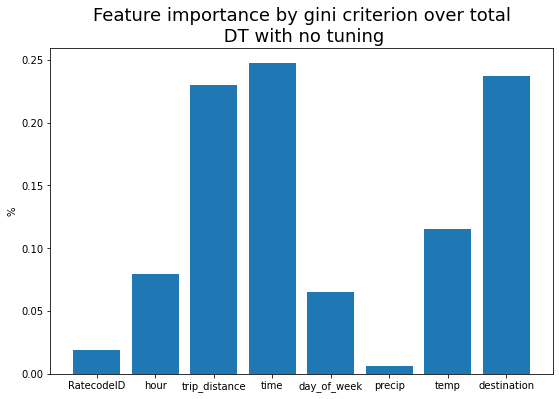

In [63]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.bar(['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination'], importance)
plt.ylabel('%')
plt.title('Feature importance by gini criterion over total\n DT with no tuning', fontsize=18)
plt.show()

### Random Forest Classifier

In [64]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)
print(classification_report(y_val, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.58      0.22      0.32    575132
           2       0.74      0.94      0.83   1813328
           3       0.65      0.20      0.30    184007
           4       0.66      0.17      0.27       348

    accuracy                           0.73   2572815
   macro avg       0.66      0.38      0.43   2572815
weighted avg       0.70      0.73      0.68   2572815



In [65]:
importance = rfc.feature_importances_

In [66]:
for i,v in enumerate(importance):
    v = round(v, 5)
    print(f'Feature: {features[i]}, Score: {v}')

Feature: RatecodeID, Score: 0.01905
Feature: hour, Score: 0.06503
Feature: trip_distance, Score: 0.26837
Feature: time, Score: 0.25323
Feature: day_of_week, Score: 0.03811
Feature: precip, Score: 0.00345
Feature: temp, Score: 0.10117
Feature: destination, Score: 0.25159


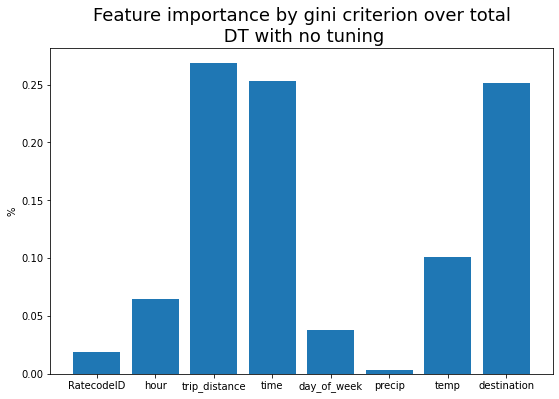

In [67]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.bar(['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination'], importance)
plt.ylabel('%')
plt.title('Feature importance by gini criterion over total\n DT with no tuning', fontsize=18)
plt.show()

In [8]:
def stratify_sample(data, att, n):
    lst_data = []
    unique_att = data[att].unique()
    for each_label in unique_att:
        lst_data.append(data[data[att]==each_label].sample(n=n))
    samples = lst_data[0]
    for each_data in lst_data[1:]:
        samples = pd.concat([samples, each_data])
    return samples

In [5]:
svc = SGDClassifier()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


NameError: name 'target_names' is not defined

In [7]:
print(classification_report(y_val, y_pred, target_names=target_names))

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.36      0.05      0.09    575132
           2       0.71      0.95      0.81   1813328
           3       0.10      0.04      0.06    184007
           4       0.00      0.00      0.00       348

    accuracy                           0.69   2572815
   macro avg       0.29      0.26      0.24   2572815
weighted avg       0.59      0.69      0.60   2572815



In [ ]:
df_result = pd.DataFrame()
df_result['Accuracy']

In [10]:
clf = OneVsRestClassifier(SGDClassifier()).fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=target_names))

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set 

              precision    recall  f1-score   support

           1       0.27      0.21      0.23    575132
           2       0.72      0.84      0.77   1813328
           3       0.16      0.00      0.00    184007
           4       0.00      0.00      0.00       348

    accuracy                           0.64   2572815
   macro avg       0.29      0.26      0.25   2572815
weighted avg       0.58      0.64      0.60   2572815



Without any parameter tuning, random forest produce the best accuracy result compared to the other classifier. Since Random forest is actually a major upgrade from the normal decision tree, where it may reduce the chances of the model being overfit, and since training an SVM may took longer than expected but with lower accuracy compared to forest, it is decided to abandon using SVM and normal DT, and continue investigating using random forest classifier instead.

However, training a large dataset take times; hence, it might be best to investigate if we could discard some of the dataset to see the trade-off between size, accuracy and training time

In [ ]:
X_train.reset_index(inplace = True)
y_train.reset_index(inplace = True)

In [118]:
X_train.drop(labels=['index'], axis=1, inplace = True)
y_train.drop(labels=['index'], axis=1, inplace = True)

In [122]:
# simulate on whether increasing the train size would increase the validation score
# find the best subset for training to reduce time needed to tune the model
rfc = RandomForestClassifier()
score_train = []
score_val = []
size = []
time_lst = []

for i in np.arange(0.05, 0.5, 0.05):
    size.append(i)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=i, random_state=42)
    sss.get_n_splits(X_train, y_train)
    
    for train_index, val_index in sss.split(X_train, y_train):
        _, X_train_size = X_train.loc[list(train_index), :], X_train.loc[list(val_index), :]
        _, y_train_size = y_train.loc[list(train_index), :], y_train.loc[list(val_index), :]
    
    start = time.time()
    rfc.fit(X_train_size, y_train_size)
    end = time.time()
    time_lst.append((end-start))
    y_pred_train = rfc.predict(X_train_size)
    y_pred = rfc.predict(X_val)
    score_train.append(round((np.sum(y_pred_train==y_train_size.values.ravel())/len(y_pred_train))*100, 2))
    score_val.append(round((np.sum(y_pred==y_val.values.ravel())/len(y_pred))*100, 2))
    
    print(f"Size {i} done")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.05 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.1 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.15000000000000002 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.2 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.25 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.3 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.35000000000000003 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.4 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Size 0.45 done


In [125]:
for i in np.arange(0.5, 1.01, 0.1):
    size.append(i)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=i, random_state=42)
    sss.get_n_splits(X_train, y_train)
    
    for train_index, val_index in sss.split(X_train, y_train):
        _, X_train_size = X_train.loc[list(train_index), :], X_train.loc[list(val_index), :]
        _, y_train_size = y_train.loc[list(train_index), :], y_train.loc[list(val_index), :]
    
    start = time.time()
    rfc.fit(X_train_size, y_train_size)
    end = time.time()
    time_lst.append((end-start))
    y_pred_train = rfc.predict(X_train_size)
    y_pred = rfc.predict(X_val)
    score_train.append(round((np.sum(y_pred_train==y_train_size.values.ravel())/len(y_pred_train))*100, 2))
    score_val.append(round((np.sum(y_pred==y_val.values.ravel())/len(y_pred))*100, 2))
    
    print(f"Size {i} done")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Size 0.5 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Size 0.6 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Size 0.7 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Size 0.7999999999999999 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Size 0.8999999999999999 done


ValueError: With n_samples=7718443, test_size=0.9999999999999999 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [130]:
size = size[:-1]

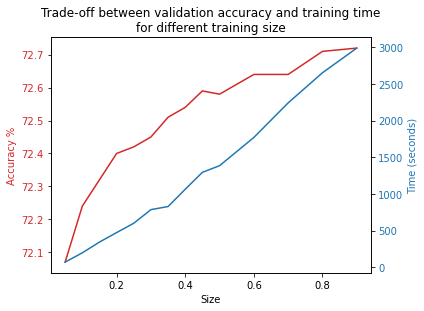

In [132]:
# Create some mock data
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Size')
ax1.set_ylabel('Accuracy %', color=color)
ax1.plot(size, score_val, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Time (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(size, time_lst, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Trade-off between validation accuracy and training time\nfor different training size')
plt.show()

The result shows that with larger dataset, accuracy tends to increase, but it may increase linearly with time as well. However, it seems that from 0.5 onwards, the rate of increase in accuracy tend to decrease compared to the previous sizes. It is arguable that adding 0.03% accuracy for 2 million testing data may be large, as it means we may be able to make correct classfication for additional 60000 trips, but this analysist decided to cut the training size to 40% of its original training size, as it has a decent training time with satisfying accuracy, that is 72.4%. Adding 0.03% with additional 2600 training time may not be the main priority in this experiment. This will only be done to speed up the developing process, as at the end, we will still use the whole training dataset to predict the test data

In [207]:
rfc = RandomForestClassifier()
rfc.fit(X_train_size, y_train_size)
y_pred = rfc.predict(X_val)
print(classification_report(y_val, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.57      0.20      0.30   1955450
           2       0.74      0.95      0.83   6165314
           3       0.65      0.17      0.27    625623
           4       0.13      0.47      0.21       348

    accuracy                           0.72   8746735
   macro avg       0.52      0.45      0.40   8746735
weighted avg       0.70      0.72      0.67   8746735



Before tuning the model, there may be another approach on improving the model, binning all of the continuous variables

In [196]:
# split the new dataset first
cluster_4_index = list(y_train[y_train['cluster_trip']==4].index)
exclude_4_index = list(set(X_train.index)-set(cluster_4_index))
X_train_cut = X_train.loc[exclude_4_index, :]
y_train_cut = y_train.loc[exclude_4_index, :]

In [197]:
X_train_cut.reset_index(inplace = True)
y_train_cut.reset_index(inplace = True)
X_train_cut.drop(labels=['index'], axis=1, inplace = True)
y_train_cut.drop(labels=['index'], axis=1, inplace = True)

In [198]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.2, random_state=42)
sss.get_n_splits(X_train_cut, y_train_cut)

for train_index, val_index in sss.split(X_train_cut, y_train_cut):
    X_train_size, X_extra_val = X_train_cut.loc[list(train_index), :], X_train_cut.loc[list(val_index), :]
    y_train_size, y_extra_val = y_train_cut.loc[list(train_index), :], y_train_cut.loc[list(val_index), :]

In [145]:
X_train_size.shape

(1543480, 8)

In [201]:
# concat the cluster 4 back, as there is only a few labels available for this cluster
X_train_size = pd.concat([X_train_size, X_train.loc[cluster_4_index]])
y_train_size = pd.concat([y_train_size, y_train.loc[cluster_4_index]])

In [202]:
# concat the validation size
X_val = pd.concat([X_val, X_extra_val])
y_val = pd.concat([y_val, y_extra_val])

In [154]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(pd.cut(X_train_size['trip_distance'], 4, retbins=True)[0])

In [162]:
arr_bins = pd.cut(X_train_size['trip_distance'], 4, retbins=True)[0]

In [168]:
arr_bins

3172326    (0.214, 24.265]
4428504    (0.214, 24.265]
2736377    (0.214, 24.265]
7270824    (0.214, 24.265]
3619491    (0.214, 24.265]
                ...       
7695590    (0.214, 24.265]
7699787    (0.214, 24.265]
7709199    (0.214, 24.265]
7714641    (0.214, 24.265]
7718261    (0.214, 24.265]
Name: trip_distance, Length: 1544523, dtype: category
Categories (4, interval[float64]): [(0.214, 24.265] < (24.265, 48.22] < (48.22, 72.175] < (72.175, 96.13]]

In [188]:
arr_bins = pd.cut(X_train_size['time'], 4, retbins=True)[0]

In [170]:
# this is an ugly code, just to check if binning the continuous may make a difference
def encode_trip(data):
    if data>=0 and data<24.265:
        return 0
    elif data>=24.265 and data<48.22:
        return 1
    elif data>=48.22 and data<72.175:
        return 2
    else:
        return 3

In [172]:
X_train_size['trip_distance'] = X_train_size['trip_distance'].apply(lambda x: encode_trip(x))
X_val['trip_distance'] = X_val['trip_distance'].apply(lambda x: encode_trip(x))

In [176]:
arr_bins = pd.cut(X_train_size['time'], 4, retbins=True)[0]

In [177]:
X_val.head()

,RatecodeID,hour,trip_distance,time,day_of_week,precip,temp,destination
9101640,1.0,16,0,0.532222,2,0.3,23.0,7576
9580347,1.0,1,0,0.131944,1,0.0,25.0,2809
5071480,1.0,9,0,0.886944,3,0.0,14.0,1939
8485892,1.0,11,0,0.389444,1,0.0,26.0,5181
10030644,1.0,20,0,0.703611,5,0.0,21.0,8034


In [178]:
rfc = RandomForestClassifier()
rfc.fit(X_train_size, y_train_size)
y_pred = rfc.predict(X_val)
print(classification_report(y_val, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.46      0.21      0.29   1955450
           2       0.73      0.91      0.81   6165314
           3       0.46      0.10      0.16    625623
           4       0.08      0.28      0.13       348

    accuracy                           0.70   8746735
   macro avg       0.43      0.37      0.35   8746735
weighted avg       0.65      0.70      0.65   8746735



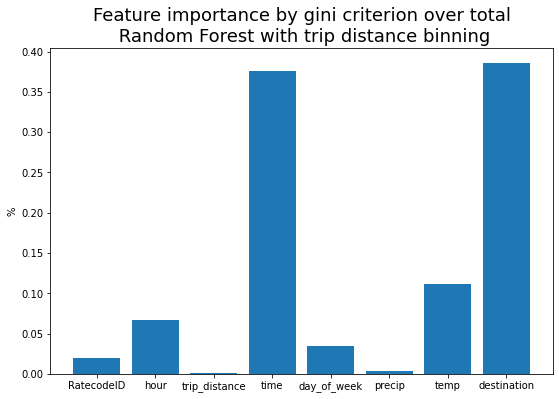

In [179]:
importance = rfc.feature_importances_
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.bar(['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination'], importance)
plt.ylabel('%')
plt.title('Feature importance by gini criterion over total\n Random Forest with trip distance binning', fontsize=18)
plt.show()

By just binning the trip distance manually, it may not work, as this may simplified the tree model, confusing the tree on the seperation of each class based on the trip distance, as it can be seen that the trip distance and time is quite similar in each class label

Try dropping precipitation and ratecode id

In [203]:
X_dropped = X_train_size[['hour', 'trip_distance', 'time', 'day_of_week', 'temp', 'destination']].copy()
X_val_dropped = X_val[['hour', 'trip_distance', 'time', 'day_of_week', 'temp', 'destination']].copy()

In [205]:
rfc = RandomForestClassifier()
rfc.fit(X_dropped, y_train_size)
y_pred = rfc.predict(X_val_dropped)
print(classification_report(y_val, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.56      0.20      0.29   1955450
           2       0.74      0.94      0.83   6165314
           3       0.60      0.14      0.23    625623
           4       0.09      0.02      0.03       348

    accuracy                           0.72   8746735
   macro avg       0.49      0.33      0.34   8746735
weighted avg       0.69      0.72      0.66   8746735



Try to change the precipitation into binary

https://water.usgs.gov/edu/activity-howmuchrain-metric.html#:~:text=Heavy%20rain%3A%20Greater%20than%204,than%2010%20mm%20per%20hour.
heavy rain: 4-8mm per hour, which is more than 0.2 inch

In [214]:
X_precip = X_train_size.copy()
X_val_precip = X_val.copy()
X_precip['precip'] = X_precip['precip'].apply(lambda x: 1 if x>0.2 else 0)
X_val_precip['precip'] = X_val_precip['precip'].apply(lambda x: 1 if x>0 else 0)

In [215]:
rfc = RandomForestClassifier()
rfc.fit(X_precip, y_train_size)
y_pred = rfc.predict(X_val_precip)
print(classification_report(y_val, y_pred, target_names=target_names))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           1       0.57      0.20      0.30   1955450
           2       0.74      0.94      0.83   6165314
           3       0.65      0.17      0.27    625623
           4       0.13      0.46      0.21       348

    accuracy                           0.72   8746735
   macro avg       0.52      0.45      0.40   8746735
weighted avg       0.69      0.72      0.67   8746735



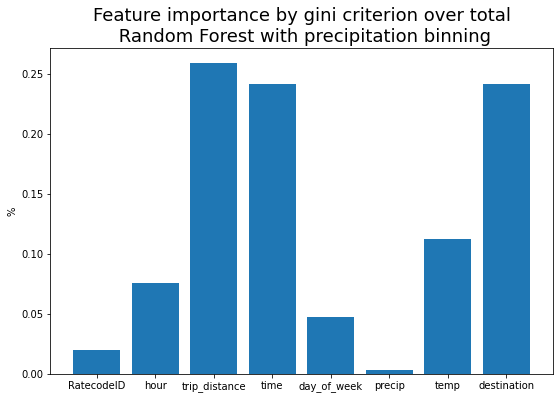

In [217]:
importance = rfc.feature_importances_
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.bar(['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination'], importance)
plt.ylabel('%')
plt.title('Feature importance by gini criterion over total\n Random Forest with precipitation binning', fontsize=18)
plt.show()

It seems that binning the precipitation is not helpfull at all. Thus, the last method that we can try is to actually predict the fare amount  and try whether this predicted attributes may help classifying the class label. However here, the error from the fare may get carried away in the tree, but it may be worth to try and investigate.

### Hyperparameter Tuning Using The Sliced Training Dataset

We have arrived with one final model:
1. Random Forest Decision Tree with attribute: trip_distance, time, ratecodeid, hour, precip, temp and destination

It is decided that the hyperparameter tuning is done in the sliced training dataset, as this may take much longer time to train. Due to the lack of time and resources, it is decided to do a tuning in the sliced dataset, but later, the result in the parameter will be implemented in the final training of the whole dataset to form the final model.

In [15]:
#1.
# the template is taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# but the knowledge on the hyperparameter tuning is from machine learning unimelb course

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Max number of samples used in each tree from X train
max_samples = [x for x in np.linspace(0.5, 0.8, 4)]
max_samples.append(None)
# Method of selecting samples for training each tree
random_state = [0, 42]

# Create the random search
random_search = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_samples': max_samples,
               'random_state': random_state}

pprint(random_search)

{'max_features': ['auto', 'log2'],
 'max_samples': [0.5, 0.6, 0.7000000000000001, 0.8, None],
 'n_estimators': [100, 125, 150, 175, 200],
 'random_state': [0, 42]}


In [10]:
X_train_one = X_train_size.copy()
X_train_one = X_train_one[X_train_one.columns[:-2]]

In [11]:
X_val_one = X_val.copy()
X_val_one = X_val[X_val.columns[:-2]]

In [16]:
# this is not ideal, it took more than 24 hours to run this ......
rf_tuned = RandomForestClassifier()
rf_random_tuning = RandomizedSearchCV(estimator = rf_tuned, param_distributions = random_search,
                                      n_iter = 2, cv = 5, random_state=42)
# Fit the random search model
rf_random_tuning.fit(X_train_size, y_train_size.values.ravel())
rf_random_tuning.best_params_

{'random_state': 42,
 'n_estimators': 125,
 'max_samples': 0.5,
 'max_features': 'log2'}

In [19]:
rf_random_tuning.best_score_

0.8050226513112678

In [20]:
y_pred = rf_random_tuning.predict(X_val)

NameError: name 'target_names' is not defined

In [22]:
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           1       0.68      0.50      0.58   1955450
           2       0.83      0.91      0.87   6165314
           3       0.86      0.71      0.78    625623
           4       0.30      0.78      0.44       348

    accuracy                           0.81   8746735
   macro avg       0.67      0.73      0.67   8746735
weighted avg       0.80      0.81      0.80   8746735



The accuracy increase by 9%. It turns out one of the reason why the model may not be working well is due to the untuned model.

# Final Prediction (moment of truth)

In [28]:
X_test = pd.read_feather('X_test.feather')

In [30]:
y_test = X_test['cluster_trip'].values.ravel()

In [35]:
X_train

,RatecodeID,hour,trip_distance,time,day_of_week,precip,temp,destination,fare_amount,misc_amount
762321,2.0,1,20.316667,0.569167,4,0.0,-1.0,3697,52.000000,0.083333
9539568,1.0,14,2.100000,0.291389,0,0.0,29.0,1326,12.500000,0.000000
6044612,1.0,22,11.140000,0.954583,4,0.0,20.0,3991,44.500000,0.010000
5143721,1.0,10,3.970000,0.703889,4,0.0,14.0,7310,26.000000,0.000000
3973347,1.0,21,1.428000,0.218222,5,0.0,15.0,8132,9.550000,0.046000
...,...,...,...,...,...,...,...,...,...,...
6945076,1.0,18,4.270000,0.337222,5,0.0,20.0,3008,17.500000,0.000000
6593012,1.0,0,1.005000,0.100139,4,0.0,18.0,2588,6.000000,0.140000
4160497,1.0,8,4.486667,0.383056,3,0.0,8.0,2340,18.666667,0.000000
5728114,1.0,0,5.100000,0.343056,4,0.0,12.0,2088,19.000000,0.110000


In [36]:
rfc_final = RandomForestClassifier(n_estimators=125, max_samples=0.5, max_features='log2', random_state=42)
rfc_final.fit(X_train[['RatecodeID', 'hour', 'trip_distance', 
                       'time', 'day_of_week', 'precip', 
                       'temp','destination']], y_train.values.ravel())

RandomForestClassifier(max_features='log2', max_samples=0.5, n_estimators=125,
                       random_state=42)

In [37]:
y_pred = rfc_final.predict(X_test[['RatecodeID', 'hour', 'day_of_week', 
                                          'precip', 'temp', 'destination', 'trip_distance', 'time']])

In [38]:
print(classification_report(y_test, y_pred, target_names=target_names))

/home/student.unimelb.edu.au/nyoewono/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.25      0.00      0.00   1023147
           2       0.72      0.99      0.84   3708741
           3       0.12      0.01      0.02    400117
           4       0.00      0.00      0.00       805

    accuracy                           0.72   5132810
   macro avg       0.27      0.25      0.21   5132810
weighted avg       0.58      0.72      0.61   5132810



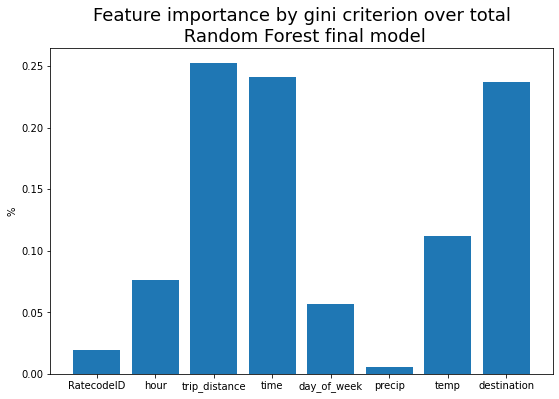

In [39]:
importance = rfc_final.feature_importances_
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.bar(['RatecodeID', 'hour', 'trip_distance', 'time', 'day_of_week', 'precip', 'temp', 'destination'], importance)
plt.ylabel('%')
plt.title('Feature importance by gini criterion over total\n Random Forest final model', fontsize=18)
plt.show()

Confusion Matrix Final Model Test
[[   1157 1016495    5495       0]
 [   2942 3677704   28095       0]
 [    517  395015    4585       0]
 [     39     757       9       0]]


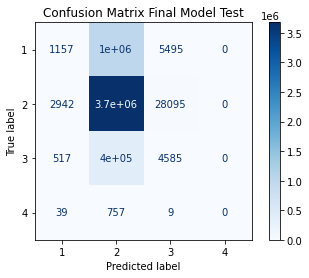

In [42]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(rfc_final, X_test[['RatecodeID', 'hour', 'day_of_week', 
                                          'precip', 'temp', 'destination', 'trip_distance', 'time']], y_test,
                            cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix Final Model Test')

print('Confusion Matrix Final Model Test')
print(disp.confusion_matrix)

As expected, when tested on real data where the distance and time is just an estimate, the result was quite disapointing. The model was not able to detect any of the cluster 4 class label. Moreover, the model was not able to detect any of the class 1 and 3, which indicate